### 1 Modelo de Balanceamento


In [2]:
# Passo 1: Importar as bibliotecas necessárias
import pandas as pd               # Para manipulação de dados
import seaborn as sns            # Para visualização de dados
import matplotlib.pyplot as plt   # Para criar gráficos
from sklearn.model_selection import train_test_split  # Para dividir os dados
from sklearn.ensemble import RandomForestClassifier   # Modelo Random Forest
from sklearn.linear_model import LogisticRegression    # Modelo de Regressão Logística
from sklearn.neighbors import KNeighborsClassifier     # Modelo KNN
from sklearn.tree import DecisionTreeClassifier        # Modelo de Árvore de Decisão
from sklearn.metrics import accuracy_score, classification_report  # Para avaliação do modelo
from sklearn.preprocessing import StandardScaler       # Para padronização dos dados
from imblearn.over_sampling import SMOTE              # Para balanceamento com SMOTE


In [3]:
# Passo 2: Carregar o arquivo CSV
file_path = 'focos_br_todos-sats_2023.csv'  # Substitua pelo caminho do seu arquivo
data = pd.read_csv(file_path, on_bad_lines='skip')

# Visualizar as primeiras linhas do DataFrame
data.head()


,latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
0,-17.55708,-57.20554,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.20,0.01,0,4.5
1,-17.55838,-57.21490,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.15,0.01,0,14.5
2,-17.62477,-57.29403,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.00,0.02,0,8.8
3,-17.62712,-57.17881,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.10,0.02,0,6.7
4,-19.44473,-53.99815,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO DO SUL,CAMAPUÃ,Cerrado,0.0,15.10,0.01,0,6.1


In [4]:
# Passo 3: Tratamento dos Dados
data = data.dropna()                     # Remove valores nulos
data = data.drop_duplicates()            # Remove linhas duplicadas

# Criar coluna com categorias de risco de fogo
data['categoria_risco'] = pd.cut(data['risco_fogo'],
                                 bins=[-float('inf'), 0.01, 0.05, float('inf')],
                                 labels=['Baixo', 'Médio', 'Alto'],
                                 include_lowest=True)

# Verificar a distribuição das classes
print("Distribuição das categorias de risco:")
print(data['categoria_risco'].value_counts())

Distribuição das categorias de risco:
categoria_risco
Alto     4050794
Baixo     291854
Médio     195616
Name: count, dtype: int64


In [5]:
# Separar variáveis dependentes e independentes
X = data[['latitude', 'longitude', 'numero_dias_sem_chuva', 'precipitacao', 'frp']]  # Variáveis independentes
y = data['categoria_risco']                                                                   # Variável dependente


In [6]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar SMOTE para balanceamento
from imblearn.over_sampling import SMOTE  # Certifique-se de que o SMOTE está importado
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Verificar a distribuição das classes após o balanceamento
print("Distribuição após o balanceamento com SMOTE:")
print(pd.Series(y_resampled).value_counts())


Distribuição após o balanceamento com SMOTE:
categoria_risco
Baixo    4050794
Médio    4050794
Alto     4050794
Name: count, dtype: int64


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Separar variáveis independentes e a variável alvo
X = data[['latitude', 'longitude', 'numero_dias_sem_chuva', 'precipitacao', 'frp']]
y = data['categoria_risco']

# Dividir os dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Treinar o modelo com balanceamento de pesos
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)
print("Relatório de Classificação com Pesos Ajustados:")
print(classification_report(y_test, y_pred))


Relatório de Classificação com Pesos Ajustados:
              precision    recall  f1-score   support

        Alto       0.60      0.73      0.66   1215238
       Baixo       0.66      0.46      0.55   1215238
       Médio       0.48      0.52      0.50   1215239

    accuracy                           0.57   3645715
   macro avg       0.58      0.57      0.57   3645715
weighted avg       0.58      0.57      0.57   3645715



In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Separar variáveis dependentes e independentes
X = data[['latitude', 'longitude', 'numero_dias_sem_chuva', 'precipitacao', 'frp']]
y = data['categoria_risco']

# Dividir em treino e teste
# Dividir os dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Definir pesos inversamente proporcionais à frequência das classes
class_weights = y_train.value_counts(normalize=True).to_dict()
class_weights = {k: 1/v for k, v in class_weights.items()}

# Treinar o modelo com pesos
model = RandomForestClassifier(random_state=42, class_weight=class_weights, n_estimators=50)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)
print("Relatório de Classificação com Pesos Ajustados:")
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [9]:
# Dividir os dados entre treinamento e teste com estratificação
from sklearn.model_selection import train_test_split  # Certifique-se de que o train_test_split está importado
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Modelos já definidos na etapa anterior
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42)
}

# Armazenar os resultados
results = {}
execution_times = {}

# Preparar o gráfico da curva ROC
plt.figure(figsize=(10, 8))

# Converter y_test para binário (se necessário)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

for model_name, model in models.items():
    print(f"\n----- {model_name} -----")

    # Medir o tempo de execução
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    # Prever as probabilidades (não as classes diretamente)
    y_prob = model.predict_proba(X_test)[:, 1]  # Pegando a probabilidade da classe positiva

    # Calcular a curva ROC
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Armazenar os resultados
    accuracy = accuracy_score(y_test, model.predict(X_test))
    execution_time = end_time - start_time
    results[model_name] = accuracy
    execution_times[model_name] = execution_time

    # Exibir os resultados
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Tempo de Execução: {execution_time:.4f} segundos")
    print("Relatório de Classificação:")
    print(classification_report(y_test, model.predict(X_test)))

# Ajustar os limites do gráfico e adicionar detalhes
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Linha diagonal (chance aleatória)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC de Diferentes Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Exibir o tempo de execução total dos modelos
print("\nResumo dos tempos de execução:")
for model_name, exec_time in execution_times.items():
    print(f"{model_name}: {exec_time:.4f} segundos")


In [10]:
# Importar bibliotecas necessárias
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import time


In [11]:
# Definir os modelos a serem testados
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42)
}


In [12]:
# Armazenar os resultados de acurácia e tempos de execução
results = {}
execution_times = {}

# Preparar o gráfico da curva ROC
plt.figure(figsize=(10, 8))



<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [13]:
# Converter y_test para binário (se necessário)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)  # Convertendo para formato binário


In [18]:
# Iterando sobre os modelos
for model_name, model in models.items():
    print(f"\n----- {model_name} -----")

    # Medir o tempo de execução do treinamento
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()



----- Naive Bayes -----

----- Logistic Regression -----

----- K-Nearest Neighbors -----

----- Decision Tree -----

----- Random Forest -----

----- AdaBoost -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



----- Gradient Boosting -----


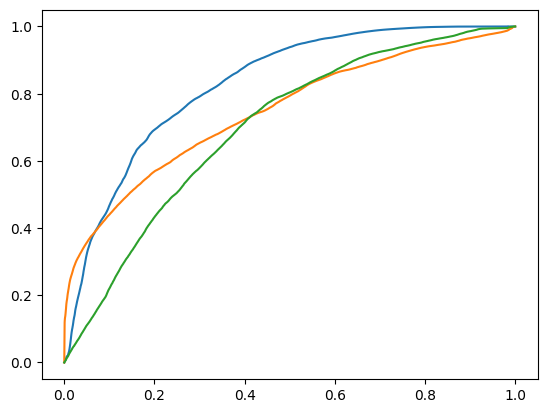

In [15]:
# Prever as probabilidades para todas as classes
y_prob = model.predict_proba(X_test)

# Calcular a curva ROC e AUC para cada classe
n_classes = y_test_bin.shape[1]  # Número de classes no problema multilabel
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Para cada classe individual
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC para a classe i
    plt.plot(fpr, tpr, label=f'Classe {i} ({model_name}) (AUC = {roc_auc:.2f})')


In [16]:
# Calcular e armazenar a acurácia e o tempo de execução
accuracy = accuracy_score(y_test, model.predict(X_test))
execution_time = end_time - start_time
results[model_name] = accuracy
execution_times[model_name] = execution_time

# Exibir os resultados
print(f"Acurácia: {accuracy:.4f}")
print(f"Tempo de Execução: {execution_time:.4f} segundos")
print("Relatório de Classificação:")
print(classification_report(y_test, model.predict(X_test)))


Acurácia: 0.5650
Tempo de Execução: 27.1580 segundos
Relatório de Classificação:
              precision    recall  f1-score   support

        Alto       0.55      0.83      0.66   1215238
       Baixo       0.80      0.34      0.48   1215238
       Médio       0.50      0.53      0.51   1215239

    accuracy                           0.56   3645715
   macro avg       0.61      0.56      0.55   3645715
weighted avg       0.61      0.56      0.55   3645715



C:\Users\Davi2004\AppData\Local\Temp\ipykernel_13156\1379117529.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


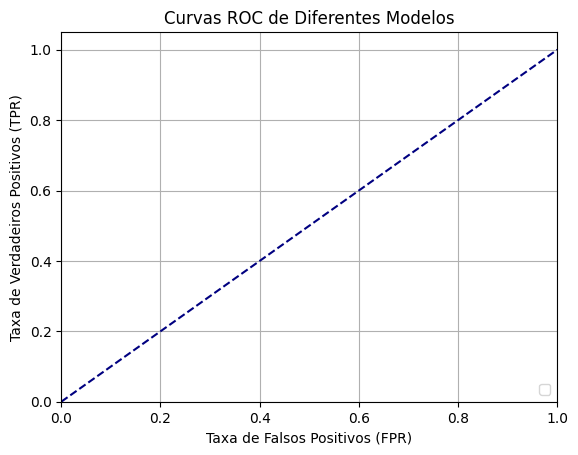

In [17]:
# Ajustar os limites do gráfico e adicionar detalhes
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Linha diagonal (chance aleatória)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC de Diferentes Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [22]:
# Exibir o tempo de execução total dos modelos
print("\nResumo dos tempos de execução:")
for model_name, exec_time in execution_times.items():
    print(f"{model_name}: {exec_time:.4f} segundos")



Resumo dos tempos de execução:
Gradient Boosting: 4550.0382 segundos



----- Naive Bayes -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Tempo de Treinamento: 28.0249 segundos

----- Logistic Regression -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Tempo de Treinamento: 63.9786 segundos

----- K-Nearest Neighbors -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Tempo de Treinamento: 80.2864 segundos

----- Decision Tree -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Tempo de Treinamento: 365.6757 segundos

----- Random Forest -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Tempo de Treinamento: 7476.6105 segundos

----- AdaBoost -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Tempo de Treinamento: 3264.1837 segundos

----- Gradient Boosting -----


c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Tempo de Treinamento: 13051.2840 segundos


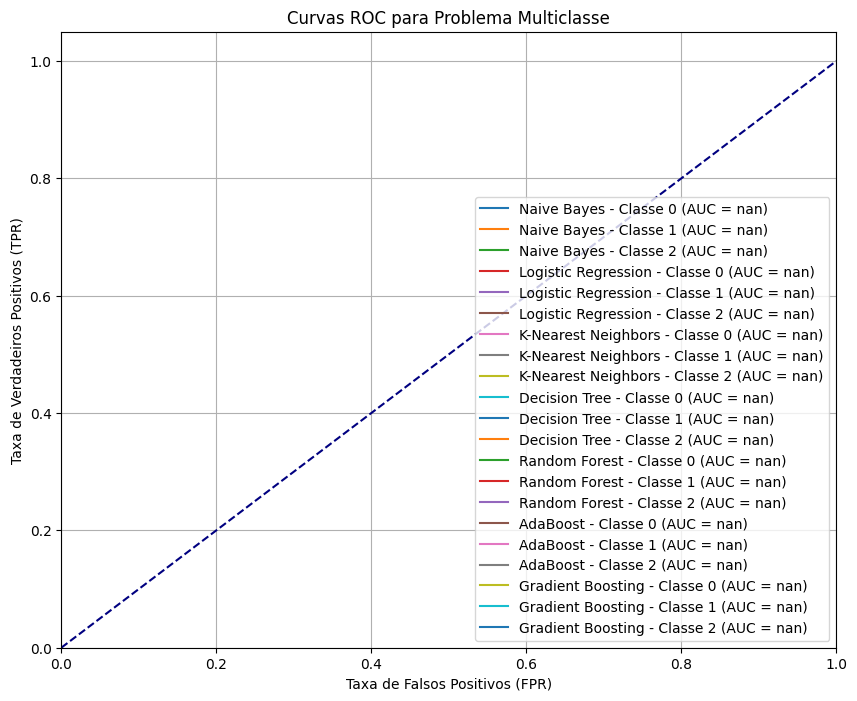

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Supondo que y_test seja o vetor de rótulos verdadeiros e y_prob as probabilidades previstas para todas as classes
# Primeiro, binarizamos as classes para facilitar o cálculo da ROC

# Se y_test for multiclasse, binarizamos:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Ajuste conforme o número de classes
n_classes = y_test_bin.shape[1]  # Número de classes binarizadas

# Preparar o gráfico da curva ROC
plt.figure(figsize=(10, 8))

# Iterar sobre os modelos para calcular e plotar a curva ROC
for model_name, model in models.items():
    print(f"\n----- {model_name} -----")

    # Treinar o modelo
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    # Prever as probabilidades para todas as classes
    y_prob = model.predict_proba(X_test)

    # Plotar a curva ROC para cada classe (One-vs-Rest)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Calcula a curva ROC para a classe i
        roc_auc = auc(fpr, tpr)

        # Plotar a curva ROC
        plt.plot(fpr, tpr, label=f'{model_name} - Classe {i} (AUC = {roc_auc:.2f})')

    # Exibir informações adicionais
    print(f"Tempo de Treinamento: {end_time - start_time:.4f} segundos")

# Adicionar detalhes ao gráfico
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Linha diagonal (chance aleatória)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC para Problema Multiclasse')
plt.legend(loc='lower right')
plt.grid(True)

# Exibir o gráfico
plt.show()


In [20]:
y_test_bin

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [24]:
for model_name, model in models.items():
    print(f"\n----- {model_name} -----")

    # Medir o tempo de execução do treinamento
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    # Prever as probabilidades para o conjunto de teste
    y_prob = model.predict_proba(X_test)[:, 1]  # Pegando a probabilidade da classe positiva

    # Calcular a curva ROC e AUC
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC do modelo
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Calcular e armazenar a acurácia e o tempo de execução
    accuracy = accuracy_score(y_test, model.predict(X_test))
    execution_time = end_time - start_time
    results[model_name] = accuracy
    execution_times[model_name] = execution_time

    # Exibir os resultados
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Tempo de Execução: {execution_time:.4f} segundos")
    print("Relatório de Classificação:")
    print(classification_report(y_test, model.predict(X_test)))



----- Naive Bayes -----


ValueError: multilabel-indicator format is not supported

C:\Users\Davi2004\AppData\Local\Temp\ipykernel_13156\44438144.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


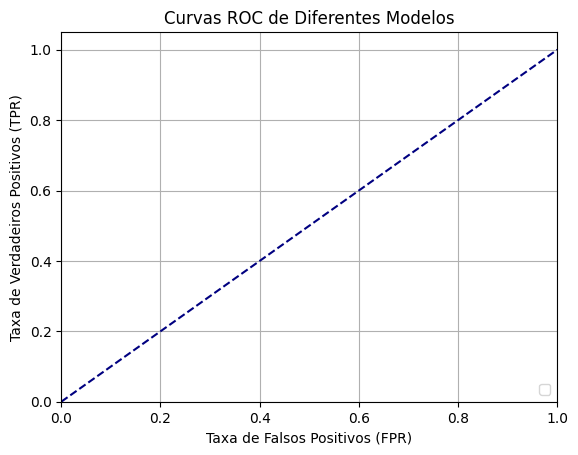

In [23]:
# Ajustar os limites do gráfico e adicionar uma linha de chance aleatória
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Linha diagonal de chance aleatória
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC de Diferentes Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [22]:
# Exibir o tempo de execução total dos modelos
print("\nResumo dos tempos de execução:")
for model_name, exec_time in execution_times.items():
    print(f"{model_name}: {exec_time:.4f} segundos")



Resumo dos tempos de execução:
Naive Bayes: 27.1580 segundos


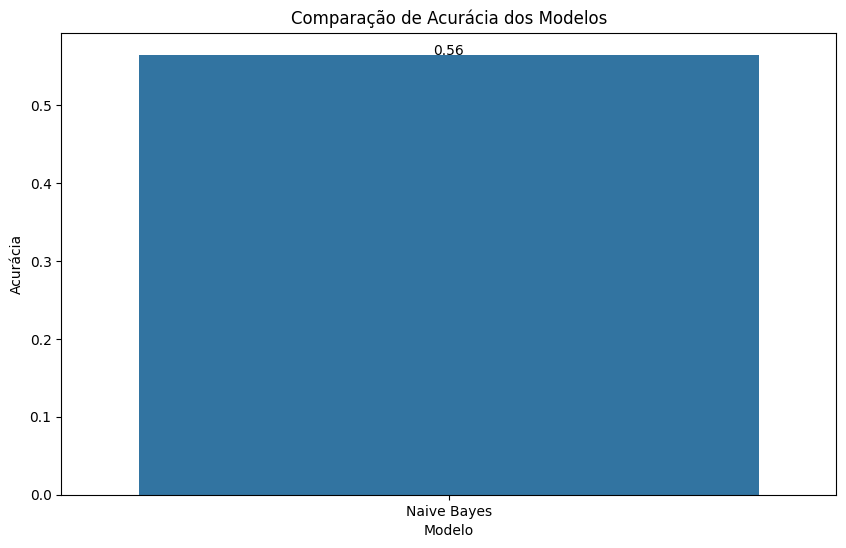

In [21]:
# Passo 6: Comparar os Resultados
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Comparação de Acurácia dos Modelos")
plt.ylabel("Acurácia")
plt.xlabel("Modelo")
for index, value in enumerate(results.values()):
    plt.text(index, value, f"{value:.2f}", ha='center')  # Adiciona rótulos de valor nas barras
plt.show()


## 2 Modelo de Balanceamento


In [ ]:
# Passo 1: Importar as bibliotecas necessárias
import pandas as pd               # Para manipulação de dados
import seaborn as sns            # Para visualização de dados
import matplotlib.pyplot as plt   # Para criar gráficos
from sklearn.model_selection import train_test_split  # Para dividir os dados
from sklearn.ensemble import RandomForestClassifier   # Modelo Random Forest
from sklearn.linear_model import LogisticRegression    # Modelo de Regressão Logística
from sklearn.neighbors import KNeighborsClassifier     # Modelo KNN
from sklearn.tree import DecisionTreeClassifier        # Modelo de Árvore de Decisão
from sklearn.metrics import accuracy_score, classification_report  # Para avaliação do modelo
from sklearn.preprocessing import StandardScaler       # Para padronização dos dados
from imblearn.over_sampling import SMOTE              # Para balanceamento com SMOTE


In [ ]:
# Passo 2: Carregar o arquivo CSV
file_path = '/content/focos_br_todos-sats_2023.csv'  # Substitua pelo caminho do seu arquivo
data = pd.read_csv(file_path, on_bad_lines='skip')

# Visualizar as primeiras linhas do DataFrame
data.head()


In [ ]:
# Passo 3: Tratamento dos Dados
data = data.dropna()                     # Remove valores nulos
data = data.drop_duplicates()            # Remove linhas duplicadas

# Criar coluna com categorias de risco de fogo
data['categoria_risco'] = pd.cut(data['risco_fogo'],
                                 bins=[-float('inf'), 0.01, 0.05, float('inf')],
                                 labels=['Baixo', 'Médio', 'Alto'],
                                 include_lowest=True)

# Verificar a distribuição das classes
print("Distribuição das categorias de risco:")
print(data['categoria_risco'].value_counts())

In [ ]:
from imblearn.under_sampling import ClusterCentroids

# Separar variáveis dependentes e independentes
X = data[['latitude', 'longitude', 'numero_dias_sem_chuva', 'precipitacao', 'frp']]  # Variáveis independentes
y = data['categoria_risco']  # Variável dependente

# Aplicar Cluster Centroids para balancear
cc = ClusterCentroids(random_state=42)
X_resampled, y_resampled = cc.fit_resample(X, y)

# Verificar a distribuição das classes após o balanceamento
print("Distribuição após o balanceamento com Cluster Centroids:")
print(pd.Series(y_resampled).value_counts())


In [ ]:
from sklearn.utils import resample

# Separar cada classe
baixo = data[data['categoria_risco'] == 'Baixo']
medio = data[data['categoria_risco'] == 'Médio']
alto = data[data['categoria_risco'] == 'Alto']

# Determinar o tamanho da classe majoritária
max_size = data['categoria_risco'].value_counts().max()

# Duplicar as amostras das classes minoritárias até igualar o tamanho da classe majoritária
baixo_resampled = resample(baixo, replace=True, n_samples=max_size, random_state=42)
medio_resampled = resample(medio, replace=True, n_samples=max_size, random_state=42)

# Concatenar todas as amostras para obter um conjunto de dados balanceado
data_balanced = pd.concat([alto, baixo_resampled, medio_resampled])

# Verificar a distribuição das classes após o balanceamento
print("Distribuição após o balanceamento com Replicação Simples:")
print(data_balanced['categoria_risco'].value_counts())


In [ ]:
# Separar variáveis dependentes e independentes
X = data[['latitude', 'longitude', 'numero_dias_sem_chuva', 'precipitacao', 'frp']]  # Variáveis independentes
y = data['categoria_risco']                                                                   # Variável dependente


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Separar variáveis dependentes e independentes
X = data[['latitude', 'longitude', 'numero_dias_sem_chuva', 'precipitacao', 'frp']]
y = data['categoria_risco']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir pesos inversamente proporcionais à frequência das classes
class_weights = y_train.value_counts(normalize=True).to_dict()
class_weights = {k: 1/v for k, v in class_weights.items()}

# Treinar o modelo com pesos
model = RandomForestClassifier(random_state=42, class_weight=class_weights)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)
print("Relatório de Classificação com Pesos Ajustados:")
print(classification_report(y_test, y_pred))


In [ ]:
# Dividir os dados entre treinamento e teste com estratificação
from sklearn.model_selection import train_test_split  # Certifique-se de que o train_test_split está importado
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


In [ ]:
# Passo 5: Treinar e Avaliar Vários Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import time
from sklearn.metrics import accuracy_score, classification_report

# Modelos ordenados por tempo de execução (do mais rápido ao mais lento)
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42)
}

# Armazenar os resultados e os tempos de execução
results = {}
execution_times = {}

for model_name, model in models.items():
    print(f"\n----- {model_name} -----")

    # Medir o tempo de execução
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    # Previsão e acurácia
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    execution_time = end_time - start_time

    # Armazenar resultados
    results[model_name] = accuracy
    execution_times[model_name] = execution_time

    # Exibir os resultados
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Tempo de Execução: {execution_time:.4f} segundos")
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

# Exibir o tempo de execução total dos modelos
print("\nResumo dos tempos de execução:")
for model_name, exec_time in execution_times.items():
    print(f"{model_name}: {exec_time:.4f} segundos")


In [ ]:
# Passo 6: Comparar os Resultados
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Comparação de Acurácia dos Modelos")
plt.ylabel("Acurácia")
plt.xlabel("Modelo")
for index, value in enumerate(results.values()):
    plt.text(index, value, f"{value:.2f}", ha='center')  # Adiciona rótulos de valor nas barras
plt.show()


Modelo 3


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib  # Para salvar e carregar o modelo


In [ ]:
# Carregar os dados
data = pd.read_csv('/content/focos_br_todos-sats_2023.csv')

# Exibir as primeiras linhas do dataset para verificação
print(data.head())


In [ ]:
# Remover colunas irrelevantes (por exemplo, 'data_pas')
data = data.drop(['data_pas'], axis=1, errors='ignore')


In [ ]:
# Separar as colunas numéricas e categóricas
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Separar variáveis dependentes (target) e independentes (features)
X = data.drop('risco_fogo', axis=1)  # Features
y = data['risco_fogo']  # Target


In [ ]:
# Dividir os dados em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# Criar o pipeline de pré-processamento com imputação e codificação
preprocessor = ColumnTransformer(
    transformers=[
        # Para as variáveis numéricas, imputar e normalizar
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputação de valores ausentes
            ('scaler', StandardScaler())  # Normalização
        ]), numeric_columns),

        # Para as variáveis categóricas, usar OneHotEncoder
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Imputação de valores ausentes
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificação OneHot
        ]), categorical_columns)
    ]
)



Modelo 3: Modelo definitivo

In [2]:
import pandas as pd               # Manipulação de dados
import seaborn as sns             # Visualização de dados
import matplotlib.pyplot as plt   # Criação de gráficos
from sklearn.model_selection import train_test_split  # Divisão do dataset
from sklearn.ensemble import RandomForestClassifier   # Modelo Random Forest
from sklearn.linear_model import LogisticRegression   # Regressão Logística
from sklearn.neighbors import KNeighborsClassifier    # K-Nearest Neighbors (KNN)
from sklearn.tree import DecisionTreeClassifier       # Árvore de Decisão
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc  # Métricas
from sklearn.preprocessing import StandardScaler, label_binarize  # Padronização e binarização
from imblearn.over_sampling import SMOTE  # Balanceamento
import time
import numpy as np


In [3]:
# Substitua pelo caminho do seu arquivo
file_path = 'focos_br_todos-sats_2023.csv'
data = pd.read_csv(file_path, on_bad_lines='skip')

# Verificar as primeiras linhas
data.head()


,latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
0,-17.55708,-57.20554,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.20,0.01,0,4.5
1,-17.55838,-57.21490,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.15,0.01,0,14.5
2,-17.62477,-57.29403,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.00,0.02,0,8.8
3,-17.62712,-57.17881,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO,POCONÉ,Pantanal,0.0,0.10,0.02,0,6.7
4,-19.44473,-53.99815,2023-01-02 02:08:00,TERRA_M-M,Brasil,MATO GROSSO DO SUL,CAMAPUÃ,Cerrado,0.0,15.10,0.01,0,6.1


In [4]:
# Remover valores nulos e duplicados
data = data.dropna()
data = data.drop_duplicates()

# Criar categorias de risco de fogo
data['categoria_risco'] = pd.cut(data['risco_fogo'],
                                 bins=[-float('inf'), 0.01, 0.05, float('inf')],
                                 labels=['Baixo', 'Médio', 'Alto'],
                                 include_lowest=True)

# Verificar a distribuição das classes
print("Distribuição das categorias de risco:")
print(data['categoria_risco'].value_counts())


Distribuição das categorias de risco:
categoria_risco
Alto     4050794
Baixo     291854
Médio     195616
Name: count, dtype: int64


In [5]:
# Definir variáveis
X = data[['latitude', 'longitude', 'numero_dias_sem_chuva', 'precipitacao', 'frp']]
y = data['categoria_risco']

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Verificar a distribuição das classes após o balanceamento
print("Distribuição após o balanceamento com SMOTE:")
print(pd.Series(y_resampled).value_counts())


Distribuição após o balanceamento com SMOTE:
categoria_risco
Baixo    4050794
Médio    4050794
Alto     4050794
Name: count, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y_resampled)


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # Importação necessária
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
import time
import numpy as np


models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42)
}



--- Avaliando Naive Bayes ---
AUC Média: 0.7583
Relatório de Classificação:
              precision    recall  f1-score   support

        Alto       0.55      0.83      0.66   1215238
       Baixo       0.80      0.34      0.48   1215238
       Médio       0.50      0.53      0.51   1215239

    accuracy                           0.56   3645715
   macro avg       0.61      0.56      0.55   3645715
weighted avg       0.61      0.56      0.55   3645715

Matriz de Confusão:
[[1003295    4296  207647]
 [ 358732  416523  439983]
 [ 474231  101072  639936]]

--- Avaliando Logistic Regression ---
AUC Média: 0.7627
Relatório de Classificação:
              precision    recall  f1-score   support

        Alto       0.60      0.73      0.66   1215238
       Baixo       0.66      0.46      0.55   1215238
       Médio       0.48      0.52      0.50   1215239

    accuracy                           0.57   3645715
   macro avg       0.58      0.57      0.57   3645715
weighted avg       0.58      

c:\Users\Davi2004\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AUC Média: 0.8026
Relatório de Classificação:
              precision    recall  f1-score   support

        Alto       0.77      0.80      0.78   1215238
       Baixo       0.70      0.39      0.50   1215238
       Médio       0.52      0.73      0.61   1215239

    accuracy                           0.64   3645715
   macro avg       0.66      0.64      0.63   3645715
weighted avg       0.66      0.64      0.63   3645715

Matriz de Confusão:
[[973851  36011 205376]
 [130337 473227 611674]
 [164266 165514 885459]]

--- Avaliando Gradient Boosting ---
AUC Média: 0.8519
Relatório de Classificação:
              precision    recall  f1-score   support

        Alto       0.79      0.79      0.79   1215238
       Baixo       0.72      0.51      0.60   1215238
       Médio       0.56      0.72      0.63   1215239

    accuracy                           0.67   3645715
   macro avg       0.69      0.67      0.67   3645715
weighted avg       0.69      0.67      0.67   3645715

Matriz de Confus

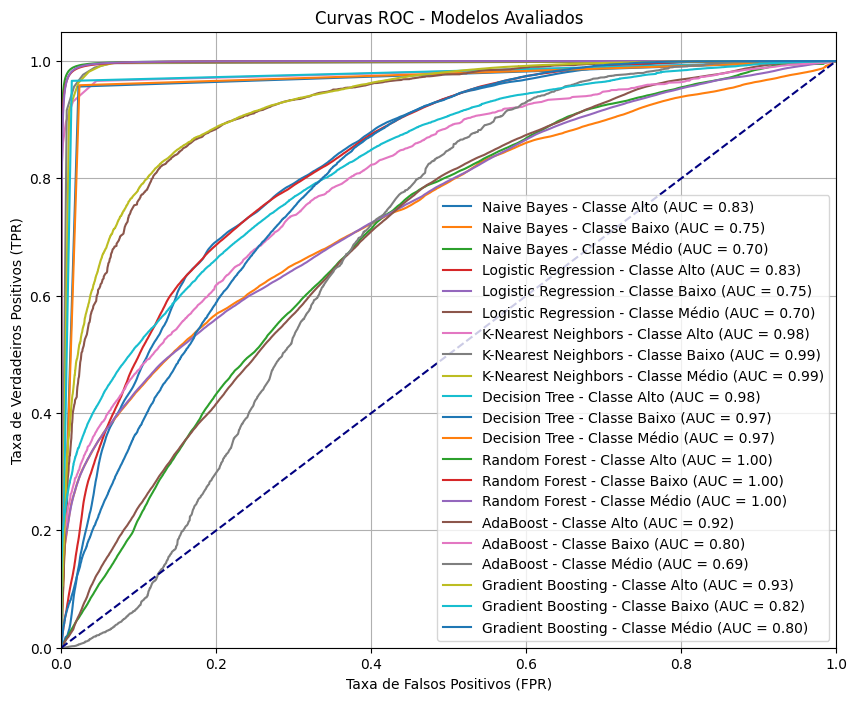

In [14]:
# Binarizar as classes para ROC
classes = y_train.unique()
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# Dicionários para armazenar métricas
roc_auc_scores = {}
f1_scores = {}
confusion_matrices = {}

# Configurar o gráfico ROC
plt.figure(figsize=(10, 8))

# Avaliar cada modelo
for model_name, model in models.items():
    print(f"\n--- Avaliando {model_name} ---")

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Prever probabilidades e classes
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    # Inicializar variáveis para ROC/AUC
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Calcular ROC e AUC para cada classe
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plotar curva ROC para cada classe
        plt.plot(fpr[i], tpr[i], label=f'{model_name} - Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Calcular AUC média
    roc_auc_scores[model_name] = np.mean(list(roc_auc.values()))

    # Calcular F1-score e Matriz de Confusão
    f1_scores[model_name] = classification_report(y_test, y_pred, output_dict=True)
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)

    # Exibir resultados
    print(f"AUC Média: {roc_auc_scores[model_name]:.4f}")
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusão:")
    print(confusion_matrices[model_name])

# Finalizar gráfico
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC - Modelos Avaliados')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [15]:
melhor_modelo = max(roc_auc_scores, key=roc_auc_scores.get)
print(f"\nMelhor Modelo com Base na AUC: {melhor_modelo}")
print(f"AUC Média: {roc_auc_scores[melhor_modelo]:.4f}")



Melhor Modelo com Base na AUC: Random Forest
AUC Média: 0.9986
